<img src='https://github.com/LinkedEarth/Logos/raw/master/PYLEOCLIM_logo_HORZ-01.png' width="800">

# Working with Age Ensembles

by  [Alexander James](https://github.com/alexkjames)

## Preamble

Quantifying chronological uncertainties, and how they influence the understanding of past changes in Earth systems, is a unique and fundamental challenge of the paleogeosciences. Without robust error determination, it is impossible to properly assess the extent to which past changes occurred simultaneously across regions, accurately estimate rates of change or the duration of abrupt events, or attribute causality – all of which limit our capacity to apply paleogeoscientific understanding to modern and future processes. With regards to the construction of an age-depth model, studies typically calculate a single “best” estimate (often the posterior median or mean), use this model to place measured paleoclimatic or paleoenvironmental data on a timescale, and then proceed to analyze the record with little to no reference to the uncertainties generated as part of the age-modeling exercise, however rigorous in its own right. 

Luckily, the vast majority of modern age-uncertainty quantification techniques estimate uncertainties by generating an “ensemble” of plausible age models: hundreds or thousands of plausible alternate age–depth relationships that are consistent with radiometric age estimates, the depositional or accumulation processes of the archive, and the associated uncertainties. By taking advantage of these ensembles to evaluate how the results of an analysis vary across the ensemble members, age-based uncertainty can be more robustly accounted for. A rising number of paleoclimate records now incorporate such age ensembles, which the [LiPD format](L1_working_with_LiPD.md) was designed to store. However, properly leveraging these often unwieldy ensemble objects for analysis can be cumbersome. In this notebook we: 

* Show how translate ensemble age-depth relationships to ensemble age-paleovariable relationships
* Show how to apply this transformatuon in two different data contexts.

The goal is to provide boilerplate code for specific solutions as well as a launching point for researchers to craft custom solutions as necessary. Further reading on age models (as well as an R implemenation for their generation) can be found in [Mckay et al. (2021)](https://doi.org/10.5194/gchron-3-149-2021) (the paper from which much of this preamble was lifted).

### Goals

- Create an `ensemble_series` object from two different file types:
    - A LiPD file
    - A NOAA file plus a CSV
- Create an `ensemble_series` object using ensembles based on ChronData tables and ensembles based on PaleoData tables.

**Reading time:**

### Keywords

LiPD; Age ensembles

### Pre-requisites

This tutorial assumes basic knowledge of Python. If you are not familiar with this coding language, check out [this  tutorial](http://linked.earth/ec_workshops_py/).

### Relevant Packages

PyLiPD; Pandas

## Data Description

This tutorial makes use of the following datasets: 

* **Crystal cave**: McCabe-Glynn, S., Johnson, K., Strong, C. et al. Variable North Pacific influence on drought in southwestern North America since AD 854. Nature Geosci 6, 617–621 (2013). https://doi.org/10.1038/ngeo1862

* **MD98-2181**: Khider, D., Jackson, C. S., and Stott, L. D., Assessing millennial-scale variability during the Holocene: A perspective from the western tropical Pacific, Paleoceanography, 29, 143– 159 (2014). https://doi:10.1002/2013PA002534.


## Demonstration

Let's import the necessary packages:

In [1]:
import ast

import pyleoclim as pyleo
import numpy as np
import pandas as pd

from pylipd.lipd import LiPD

# Ensemble Series creation function

Here we define the function we'll use to create ensembles. We'll require that the user pass in a vector or matrix for paleo data values, a vector for depth related to the paleo data, a chron vector or matrix, and a vector for depth related to the chron data. The first dimension of the paleo data values and the first dimension of the paleo depth vector should be the same. The same goes for the chron depth vector and the chron data values. Note that if a matrix is passed for paleo values, a vector should be passed for chron values and vice versa. Feel free to copy and use this function at will!

In [2]:
def mapDataToEnsemble(chronValues, paleoValues, chronDepth, paleoDepth,
                             value_name = None,value_unit = None,time_name = None,time_unit = None, ensembleMode='chron'):
    """ Map the depth for the ensemble age values to the paleo values

    Parameters
    ----------

    chronValues : array
        A vector or matrix of containing chron data values. 
        If a matrix, realizations should be stored in columns.
        Must have same number of rows/elements as chronDepth.
        
    paleoValues : array
        A vector or matrix containing the paleo data values. 
        If a matrix, realizations should be stored in columns.
        Must have same number of rows/elements as paleoDepth.
        
    chronDepth : 1D array
        A vector of depth. The vector should have the same
        length as the number of rows in the chronValues
        
    paleoDepth : 1D array
        A vector corresponding to the depth at which there
        are paleodata information
        
    value_name : str
        Paleo data value name
    
    value_unit : str
        Paleo data value unit
    
    time_name : str
        Time name
    
    time_unit : str
        Time unit

    ensembleMode : str; {'chron','paleo'}
        Whether the ensemble is stored in the chronValues or paleoValues. 
        Default is 'chron'.

    Returns
    -------

    ensemble : pyleoclim.EnsembleSeries
        A matrix of age ensemble on the PaleoData scale

    """

    #Make sure that numpy arrays were given and try to coerce them into vectors if possible
        
    chronDepth=np.squeeze(np.array(chronDepth))
    paleoDepth = np.squeeze(np.array(paleoDepth))

    #Check that arrays are vectors for np.interp
    if chronDepth.ndim > 1:
        raise ValueError('chronDepth has more than one dimension, please pass it as a 1D array')
    if paleoDepth.ndim > 1:
        raise ValueError('paleoDepth has more than one dimension, please pass it as a 1D array')

    if ensembleMode == 'chron':
        paleoValues = np.squeeze(np.array(paleoValues))
        if paleoValues.ndim > 1:
            raise ValueError('paleoValues has more than one dimension and `ensembleMode` is set to "chron"')
        #Interpolate
        ensembleValuesToPaleo = np.zeros((len(paleoDepth),np.shape(chronValues)[1])) #placeholder
        for i in np.arange(0,np.shape(chronValues)[1]):
            ensembleValuesToPaleo[:,i]=np.interp(paleoDepth,chronDepth,chronValues[:,i])

        if len(chronDepth)!=np.shape(chronValues)[0]:
            raise ValueError("Ensemble depth and age need to have the same length")
            
        if len(paleoValues) != len(paleoDepth):
            raise ValueError("Paleo depth and age need to have the same length")
        
        series_list = []
        
        for s in ensembleValuesToPaleo.T:
            series_tmp = pyleo.Series(time=s, value=paleoValues,
                        verbose=False,
                        clean_ts=False,
                        value_name=value_name,
                        value_unit=value_unit,
                        time_name=time_name,
                        time_unit=time_unit)
            series_list.append(series_tmp)

    elif ensembleMode == 'paleo':
        chronValues = np.squeeze(np.array(chronValues))
        if chronValues.ndim > 1:
            raise ValueError('chronValues has more than one dimension and `ensembleMode` is set to "paleo"')
        #Interpolate
        ensembleValuesToPaleo = np.zeros((len(chronDepth),np.shape(paleoValues)[1])) #placeholder
        for i in np.arange(0,np.shape(paleoValues)[1]):
            ensembleValuesToPaleo[:,i]=np.interp(chronDepth,paleoDepth,paleoValues[:,i])

        if len(paleoDepth)!=np.shape(paleoValues)[0]:
            raise ValueError("Ensemble depth and age need to have the same length")
            
        if len(chronValues) != len(chronDepth):
            raise ValueError("Paleo depth and age need to have the same length")
        
        series_list = []
        
        for s in ensembleValuesToPaleo.T:
            series_tmp = pyleo.Series(time=chronValues, value=s,
                        verbose=False,
                        clean_ts=False,
                        value_name=value_name,
                        value_unit=value_unit,
                        time_name=time_name,
                        time_unit=time_unit)
            series_list.append(series_tmp)

    else:
        raise ValueError('ensembleMode not recognized, please pass "chron" or "paleo"')
    
    ensemble = pyleo.EnsembleSeries(series_list=series_list)

    return ensemble




# Ensemble series from chron ensemble

In the following two examples we will create `EnsembleSeries` objects from ensembles where uncertainty is represented by variations in the time axis. This structure is typically used to represent dating uncertainty.

## Example from LiPD

For this example we'll use the [Crystal Cave](https://doi.org/10.1038/ngeo1862) record.

The easiest way to load data from a LiPD file in Python is to use the [PyLiPD](https://github.com/LinkedEarth/pylipd) package. Tutorials on basic usage of the PyLiPD package can be found in the [PyLiPD Tutorials](https://github.com/LinkedEarth/pylipdTutorials) GitHub repository.

In [3]:
#Create a path to the data
filename = '../data/Crystal.McCabe-Glynn.2013.lpd'

#Initialize the lipd object
D = LiPD()

#Load the data
D.load(filename)

Loading 1 LiPD files


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  3.41it/s]

Loaded..


You can create a DataFrame containing relevant information about the ensembles:
(1) ensembleTable : the full name of the table (relevant if one exists)
(2) EnsembleVariableValues: Each column represents a member of the ensemble. 
(3) information about depth

Note that the DataFrame includes information about units, which may be needed to convert the age-depth found in the ensemble table vs the other found with the data.

<div class="alert alert-warning">
Check the units!!!!!
</div>


In [4]:
#Pull the ensemble tables into a dataframe
ensemble_df = D.get_ensemble_tables()
ensemble_df

,datasetName,ensembleTable,ensembleVariableName,ensembleVariableValues,ensembleVariableUnits,ensembleDepthName,ensembleDepthValues,ensembleDepthUnits,notes
0,Crystal.McCabe-Glynn.2013,http://linked.earth/lipd/Crystal.McCabe-Glynn....,Year,"[[2007.0, 2007.0, 2008.0, 2007.0, 2007.0, 2007...",AD,depth,"[0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0...",mm,None


You can flatten the information contained in a LiPD file into a DataFrame that can be used for further querying. The columns correspond to metadata properties while each row corresponds to a specific variable (a column in the csv file). 

In [5]:
#Pull the paleo data into a list. We use all the available data set names because our file only contains one dataset
timeseries,df = D.get_timeseries(D.get_all_dataset_names(),to_dataframe=True)
df

Extracting timeseries from dataset: Crystal.McCabe-Glynn.2013 ...


,mode,time_id,geo_meanLon,geo_meanLat,geo_meanElev,geo_type,investigator,hasUrl,pub1_author,pub1_volume,...,paleoData_TSid,paleoData_hasMaxValue,paleoData_hasMinValue,paleoData_hasMedianValue,paleoData_number,paleoData_hasMeanValue,paleoData_proxyObservationType,paleoData_variableType,paleoData_values,paleoData_inferredVariableType
0,paleoData,age,-118.82,36.59,1386.0,Feature,"[{'name': 'S. McCabe-Glynn'}, {'name': 'C. Str...",https://data.mint.isi.edu/files/lipd/Crystal.M...,Max Berkelhammer Courtenay Strong;Hai Cheng an...,6.0,...,PYT2H04CZ1R,-7.89,10.43,-9.03,3,-9.021176,D18O,measured,"[-8.01, -8.23, -8.61, -8.54, -8.6, -9.08, -8.9...",NaN
1,paleoData,age,-118.82,36.59,1386.0,Feature,"[{'name': 'S. McCabe-Glynn'}, {'name': 'C. Str...",https://data.mint.isi.edu/files/lipd/Crystal.M...,Max Berkelhammer Courtenay Strong;Hai Cheng an...,6.0,...,PYT0EBE8TVT,2007.70,851.90,1448.45,2,1427.506736,NaN,inferred,"[2007.7, 2007.0, 2006.3, 2005.6, 2004.9, 2004....",Age
2,paleoData,age,-118.82,36.59,1386.0,Feature,"[{'name': 'S. McCabe-Glynn'}, {'name': 'C. Str...",https://data.mint.isi.edu/files/lipd/Crystal.M...,Max Berkelhammer Courtenay Strong;Hai Cheng an...,6.0,...,PYTVDX1FMFG,104.40,0.05,51.45,1,51.292647,Depth,measured,"[0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0...",NaN


To see which properties are available, you can return the name of the columns in the dataframe:

In [6]:
df.columns

Index(['mode', 'time_id', 'geo_meanLon', 'geo_meanLat', 'geo_meanElev',
       'geo_type', 'investigator', 'hasUrl', 'pub1_author', 'pub1_volume',
       'pub1_abstract', 'pub1_pages', 'pub1_journal', 'pub1_title',
       'pub1_year', 'pub1_pubDataUrl', 'pub1_doi', 'pub1_DOI',
       'funding1_agency', 'funding1_grant', 'funding2_agency',
       'funding2_grant', 'funding3_grant', 'funding3_agency', 'createdBy',
       'dataSetName', 'lipdVersion', 'archiveType', 'tableType',
       'paleoData_missingValue', 'paleoData_filename', 'paleoData_tableName',
       'age', 'ageUnits', 'depth', 'depthUnits',
       'paleoData_hasResolution_hasMinValue',
       'paleoData_hasResolution_hasMeanValue',
       'paleoData_hasResolution_hasMedianValue',
       'paleoData_hasResolution_hasMaxValue', 'paleoData_takenAtDepth',
       'paleoData_variableName', 'paleoData_units', 'paleoData_TSid',
       'paleoData_hasMaxValue', 'paleoData_hasMinValue',
       'paleoData_hasMedianValue', 'paleoData_numbe

Let's have a look at the names of the variable stored in the DataFrame:

In [7]:
#Identify the variable of interest. In this case its d18o
df['paleoData_variableName']

0     d18o
1      age
2    depth
Name: paleoData_variableName, dtype: object

We are interested in d18O, so we identify the row that contains d18O as the paleo data variable name.

In [8]:
df_row = df.loc[df['paleoData_variableName']=='d18o']

paleoDepth = np.array(*df_row['depth'])
paleoValues = np.array(*df_row['paleoData_values'])

#It's wise to make sure our units all make sense so we'll pull these as well
paleo_depth_units = df_row['depthUnits']

#The stored value name and value unit are horrendously formatted, so we'll hard code them using info from the dataframe
value_name = 'd18O'
value_unit = 'permil VPDB'

#We can access the row of interest in our ensemble table via indexing by 0 (because there's just the one row anyway)
chronDepth = ensemble_df.iloc[0]['ensembleDepthValues']
chronValues = ensemble_df.iloc[0]['ensembleVariableValues']

#Getting depth units, time name, and time units from our ensemble table
ensemble_depth_units = ensemble_df.iloc[0]['ensembleDepthUnits']

#The way time name and units are stored in our ensemble dataframe are a bit wonky, so we'll do some organization of our own
time_name = 'Time'
time_unit = f'{ensemble_df.iloc[0]["ensembleVariableName"]} {ensemble_df.iloc[0]["ensembleVariableUnits"]}'

We do the same for `chronDepth`

In [9]:
chronDepth = ensemble_df.iloc[0]['ensembleDepthValues']

chronDepth

array([1.000e-01, 1.500e-01, 2.000e-01, ..., 1.042e+02, 1.043e+02,
       1.044e+02])

Much better! We can check that the shapes are appropriate as well.

In [10]:
print(f'Num rows in chronValues: {chronValues.shape[0]}, Length of chronDepth: {len(chronDepth)}')

Num rows in chronValues: 1053, Length of chronDepth: 1053


All looks well. Now we can pass everything into `mapDataToEnsemble`

In [11]:
ensemble = mapDataToEnsemble(
    chronValues=chronValues,
    paleoValues=paleoValues,
    chronDepth=chronDepth,
    paleoDepth=paleoDepth,
    value_name=value_name,
    value_unit=value_unit,
    time_name=time_name,
    time_unit=time_unit
)

And voila! We can leverage all of pyleoclim's wonderful ensemble functionalities.

(<Figure size 1600x1000 with 1 Axes>,
 <Axes: xlabel='Time [Year AD]', ylabel='d18O [permil VPDB]'>)

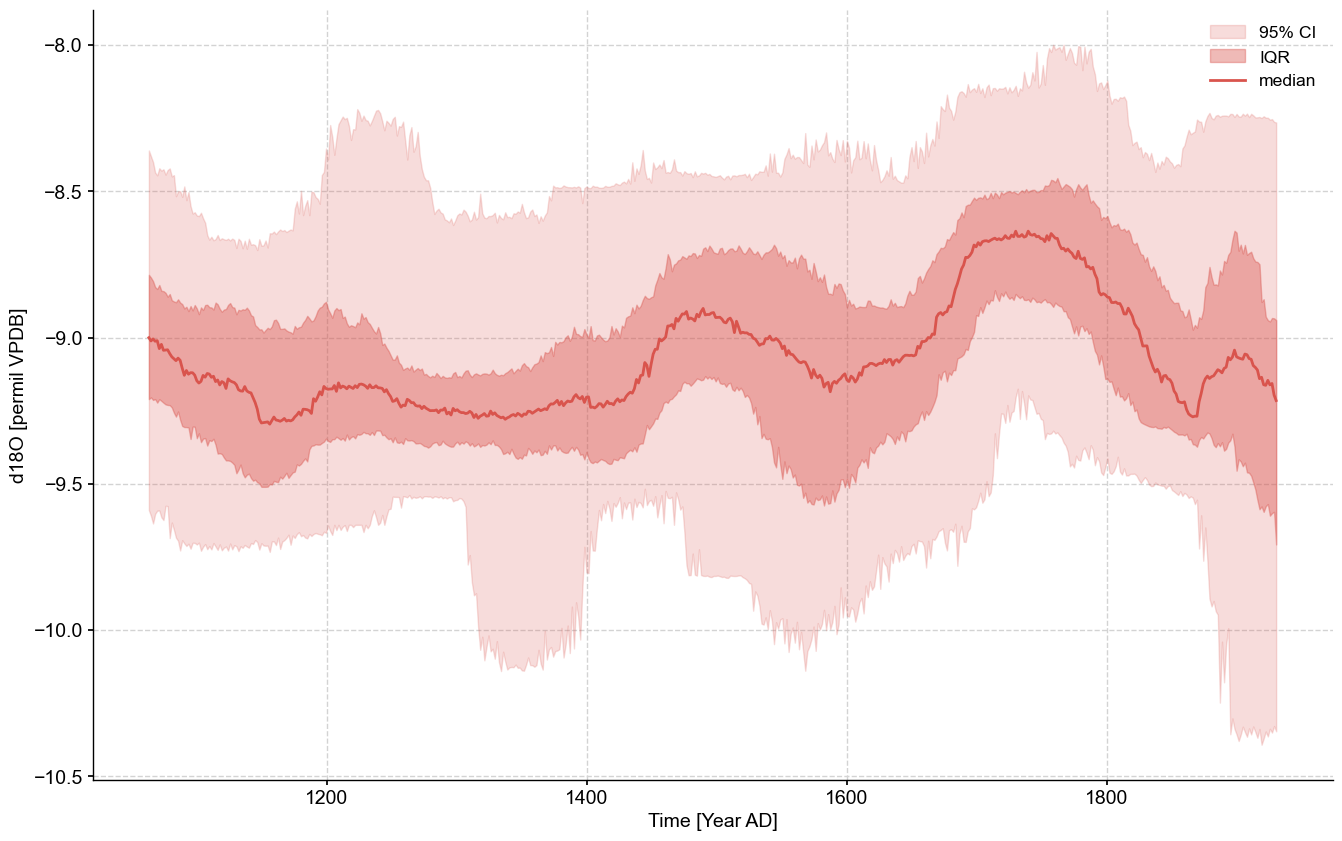

In [12]:
ensemble.common_time().plot_envelope(figsize=(16,10))

# Example from NOAA

For this example we'll use the [MD982181](https://www.ncei.noaa.gov/access/paleo-search/study/2634) record from [Khider et al. (2014)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2013PA002534). We will source the CSV file containing the age ensemble for the SST values from this record from the [Linked Earth wiki page](https://wiki.linked.earth/File:MD982181.Khider.2014.chron1model1ensemble.csv), though a local CSV file could also be used here with minimal changes.

In [13]:
#Loading the ensemble tables. Note that column 0 corresponds to depth

ensemble_url = 'https://wiki.linked.earth/wiki/images/7/79/MD982181.Khider.2014.chron1model1ensemble.csv'

ensemble_df = pd.read_csv(ensemble_url,header=None)

ensemble_df

,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,1000
0,1.0,207.301109,-21.273103,359.894201,3.950743,69.791337,195.918556,477.506539,254.071725,18.043039,...,200.832011,29.981959,159.156188,-30.030879,10.998169,256.535747,232.055674,61.422668,-24.770834,475.549540
1,2.5,210.598385,-6.095219,363.537231,19.011842,79.372074,202.387822,478.016110,257.074060,29.545646,...,207.932983,38.840758,167.586782,-18.344618,17.123170,262.956721,235.486451,71.243925,-18.329537,475.748343
2,5.0,216.040623,19.369267,369.630612,44.252513,95.396047,213.157541,478.839723,262.061321,48.814435,...,219.792022,53.661308,181.704918,1.189714,27.295888,273.711759,241.180553,87.665771,-7.626766,476.046104
3,6.5,219.280420,34.728605,373.297041,59.463559,105.037349,219.613424,479.321568,265.045696,60.422642,...,226.919006,62.580463,190.208029,12.937785,33.382424,280.190421,244.585561,97.544358,-1.220809,476.208644
4,7.0,220.356966,39.859076,374.520562,64.542743,108.254684,221.764597,479.480550,266.039429,64.298267,...,229.296199,65.557071,193.046673,16.857451,35.409002,282.353374,245.719046,100.840599,0.912427,476.260687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332,827.0,9434.248215,9545.771005,9596.976203,9588.136195,9438.630060,9611.671864,9514.355046,9613.503470,9515.947093,...,9441.197068,9509.291601,9584.105141,9487.163021,9432.573204,9528.250540,9577.714737,9442.864368,9570.410846,9500.091340
333,836.0,9662.543323,9749.147272,9818.449843,9818.782493,9638.010047,9835.377593,9714.793979,9837.351019,9721.120860,...,9644.065902,9728.433304,9795.061924,9676.390919,9623.447075,9734.211473,9803.351304,9649.143650,9780.641448,9718.151948
334,839.0,9739.420208,9817.390937,9892.732202,9896.475674,9705.027332,9910.431322,9781.949176,9912.636525,9790.081021,...,9712.162198,9802.252278,9865.803631,9739.802457,9687.383488,9803.283922,9879.292011,9718.456343,9851.235118,9791.439448
335,843.0,9842.408624,9908.664339,9992.061086,10000.572811,9794.731539,10010.805766,9871.703033,10013.435160,9882.382981,...,9803.252697,9901.159253,9960.389782,9824.560618,9772.826640,9895.641914,9981.000988,9811.218375,9945.682572,9889.530993


The format here is different from the one we encountered from the LiPD file, so we'll do things a bit differently. Outside of LiPD (and sometimes within it), the format of age ensemble tables can vary considerably. We'll show how to approach formatting this table in a minute. First, let's look at the paleo data we're working with.

In [14]:
url = 'https://www.ncei.noaa.gov/pub/data/paleo/contributions_by_author/khider2014/khider2014-sst.txt'


df = pd.read_csv(url, sep = '\t', skiprows=137)

df

,depth_cm,Mg/Ca-g.rub-w,d18Og.rub-w,age_calyrBP,age-2.5%,age-34%,age-68%,age-97.5%,SST,SST-2.5%,SST-34%,SST-68%,SST-97.5%,δ18Osw,δ18Osw 2.5%,δ18Osw 34%,δ18Osw 68%,δ18Osw 97.5%
0,1.0,5.21,-999.990,199,-63,96,237,428,27.80,26.88,27.63,28.04,28.74,-999.99,-999.99,-999.99,-999.99,-999.99
1,2.5,5.04,-2.830,205,-53,104,242,429,27.41,26.47,27.23,27.65,28.35,0.02,-0.32,-0.05,0.10,0.35
2,3.0,-999.99,-2.810,207,-50,107,244,430,-999.99,-999.99,-999.99,-999.99,-999.99,-999.99,-999.99,-999.99,-999.99,-999.99
3,4.0,-999.99,-2.780,211,-44,112,248,432,-999.99,-999.99,-999.99,-999.99,-999.99,-999.99,-999.99,-999.99,-999.99,-999.99
4,5.0,5.10,-2.788,216,-38,117,252,433,27.55,26.58,27.36,27.79,28.49,0.09,-0.25,0.01,0.17,0.43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,831.0,-999.99,-2.580,9604,9450,9563,9649,9764,-999.99,-999.99,-999.99,-999.99,-999.99,-999.99,-999.99,-999.99,-999.99,-999.99
451,836.0,5.14,-2.650,9722,9565,9677,9770,9886,27.64,26.67,27.46,27.87,28.59,0.01,-0.33,-0.06,0.09,0.34
452,839.0,5.77,-2.620,9793,9634,9747,9844,9960,28.95,28.08,28.77,29.17,29.88,0.30,-0.04,0.23,0.38,0.63
453,843.0,5.45,-2.640,9888,9726,9839,9942,10059,28.30,27.42,28.14,28.53,29.19,0.13,-0.20,0.07,0.22,0.47


The missing value field was `-999`, let's change it to NaN.

In [15]:
df.replace(-999.99, np.NaN, inplace=True)

In [16]:
df

,depth_cm,Mg/Ca-g.rub-w,d18Og.rub-w,age_calyrBP,age-2.5%,age-34%,age-68%,age-97.5%,SST,SST-2.5%,SST-34%,SST-68%,SST-97.5%,δ18Osw,δ18Osw 2.5%,δ18Osw 34%,δ18Osw 68%,δ18Osw 97.5%
0,1.0,5.21,NaN,199,-63,96,237,428,27.80,26.88,27.63,28.04,28.74,NaN,NaN,NaN,NaN,NaN
1,2.5,5.04,-2.830,205,-53,104,242,429,27.41,26.47,27.23,27.65,28.35,0.02,-0.32,-0.05,0.10,0.35
2,3.0,NaN,-2.810,207,-50,107,244,430,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4.0,NaN,-2.780,211,-44,112,248,432,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5.0,5.10,-2.788,216,-38,117,252,433,27.55,26.58,27.36,27.79,28.49,0.09,-0.25,0.01,0.17,0.43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,831.0,NaN,-2.580,9604,9450,9563,9649,9764,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
451,836.0,5.14,-2.650,9722,9565,9677,9770,9886,27.64,26.67,27.46,27.87,28.59,0.01,-0.33,-0.06,0.09,0.34
452,839.0,5.77,-2.620,9793,9634,9747,9844,9960,28.95,28.08,28.77,29.17,29.88,0.30,-0.04,0.23,0.38,0.63
453,843.0,5.45,-2.640,9888,9726,9839,9942,10059,28.30,27.42,28.14,28.53,29.19,0.13,-0.20,0.07,0.22,0.47


As in the crystal cave example, loading the data is fairly simple. Most of the legwork is getting our data into the appropriate format. We can pull the necessary paleo data from the NOAA dataframe. Note that we need to check the column names as sometimes unusual syntax will throw a wrench in the works. In this example the `Depth` column is in fact `depth_cm`.

In [17]:
df.columns

Index(['depth_cm', 'Mg/Ca-g.rub-w', 'd18Og.rub-w', 'age_calyrBP', 'age-2.5%',
       'age-34%', 'age-68%', 'age-97.5%', 'SST ', 'SST-2.5%', 'SST-34%',
       'SST-68%', 'SST-97.5%', 'δ18Osw', 'δ18Osw 2.5%', 'δ18Osw 34%',
       'δ18Osw 68%', 'δ18Osw 97.5%'],
      dtype='object')

In this example the metadata is a bit less available (one of the benefits of using the LiPD format is the especially well formatted metadata, an advantage we don't have in this example), so we need to do a bit more by hand.

In [18]:
paleoValues = df['SST '].to_numpy().flatten()
paleoDepth = df['depth_cm'].to_numpy().flatten()

value_name = 'SST'
value_unit = 'deg C'

time_name = 'Age'
time_unit = 'Year BP'

Now for the ensemble values.

In [19]:
ensemble_df

,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,1000
0,1.0,207.301109,-21.273103,359.894201,3.950743,69.791337,195.918556,477.506539,254.071725,18.043039,...,200.832011,29.981959,159.156188,-30.030879,10.998169,256.535747,232.055674,61.422668,-24.770834,475.549540
1,2.5,210.598385,-6.095219,363.537231,19.011842,79.372074,202.387822,478.016110,257.074060,29.545646,...,207.932983,38.840758,167.586782,-18.344618,17.123170,262.956721,235.486451,71.243925,-18.329537,475.748343
2,5.0,216.040623,19.369267,369.630612,44.252513,95.396047,213.157541,478.839723,262.061321,48.814435,...,219.792022,53.661308,181.704918,1.189714,27.295888,273.711759,241.180553,87.665771,-7.626766,476.046104
3,6.5,219.280420,34.728605,373.297041,59.463559,105.037349,219.613424,479.321568,265.045696,60.422642,...,226.919006,62.580463,190.208029,12.937785,33.382424,280.190421,244.585561,97.544358,-1.220809,476.208644
4,7.0,220.356966,39.859076,374.520562,64.542743,108.254684,221.764597,479.480550,266.039429,64.298267,...,229.296199,65.557071,193.046673,16.857451,35.409002,282.353374,245.719046,100.840599,0.912427,476.260687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332,827.0,9434.248215,9545.771005,9596.976203,9588.136195,9438.630060,9611.671864,9514.355046,9613.503470,9515.947093,...,9441.197068,9509.291601,9584.105141,9487.163021,9432.573204,9528.250540,9577.714737,9442.864368,9570.410846,9500.091340
333,836.0,9662.543323,9749.147272,9818.449843,9818.782493,9638.010047,9835.377593,9714.793979,9837.351019,9721.120860,...,9644.065902,9728.433304,9795.061924,9676.390919,9623.447075,9734.211473,9803.351304,9649.143650,9780.641448,9718.151948
334,839.0,9739.420208,9817.390937,9892.732202,9896.475674,9705.027332,9910.431322,9781.949176,9912.636525,9790.081021,...,9712.162198,9802.252278,9865.803631,9739.802457,9687.383488,9803.283922,9879.292011,9718.456343,9851.235118,9791.439448
335,843.0,9842.408624,9908.664339,9992.061086,10000.572811,9794.731539,10010.805766,9871.703033,10013.435160,9882.382981,...,9803.252697,9901.159253,9960.389782,9824.560618,9772.826640,9895.641914,9981.000988,9811.218375,9945.682572,9889.530993


In [20]:
chronDepth = ensemble_df[0].to_numpy() #The depth values in this case are stored in column 0

chronValues = ensemble_df[ensemble_df.columns.values[1:]].to_numpy() 

Checking that our dimensions are as we expect:

In [21]:
print(f'Num rows in chronValues: {chronValues.shape[0]}, Length of chronDepth: {len(chronDepth)}')

Num rows in chronValues: 337, Length of chronDepth: 337


In [22]:
ensemble = mapDataToEnsemble(
    chronValues=chronValues,
    paleoValues=paleoValues,
    chronDepth=chronDepth,
    paleoDepth=paleoDepth,
    value_name=value_name,
    value_unit=value_unit,
    time_name=time_name,
    time_unit=time_unit
)

And again we can leverage Pyleoclim's ensemble capabilities!

Performing spectral analysis on individual series: 100%|██████████| 999/999 [00:00<00:00, 1602.52it/s]


(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Period [Years BP]', ylabel='PSD'>)

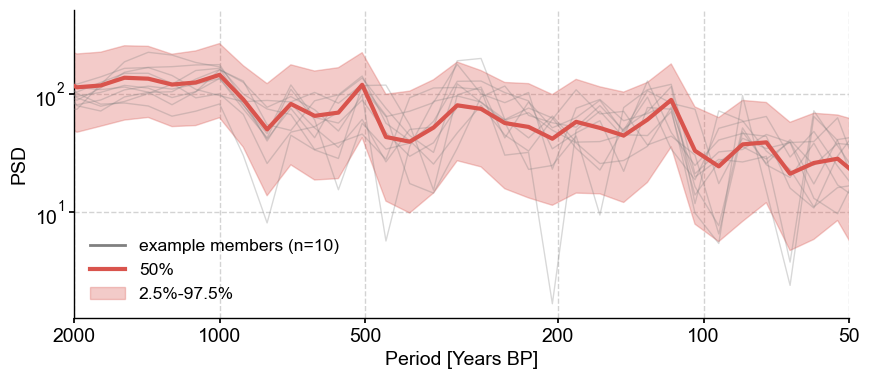

In [33]:
ensemble.spectral().plot_envelope()

# Ensemble series from paleo ensemble

In the following example we'll create an `EnsembleSeries` object where uncertainty is represented by variations in the value axis. This structure is more typically used to represent measurement uncertainty, though depending on the age modeling method used it can also be used to represent dating uncertainty.

In order to do this we'll load all of our data as before, only we'll create a matrix for `paleoValues` and a one dimensional matrix for `chronValues`. We'll specify that our ensemble is contained in the `paleoValues` argument by passing `ensembleMode = 'paleo'` to our `mapDataToEnsemble` function.

In order to get at a paleo based ensemble table we'll create a custom pyLiPD query. If you want to learn more about how to construct these queries for yourself, we recommend checking out the [pyLiPD Tutorials](https://github.com/LinkedEarth/pylipdTutorials).

In [24]:
D = LiPD()

D.load(['../data/MD982181.Khider.2014.lpd'])

Loading 1 LiPD files


100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

Loaded..


In [25]:
query = """
    PREFIX le: <http://linked.earth/ontology#>

    SELECT ?datasetName ?ensembleTable ?ensembleVariableName ?ensembleVariableValues ?ensembleVariableUnits ?ensembleDepthName ?ensembleDepthValues ?ensembleDepthUnits ?notes ?methodobj ?methods
    WHERE {
        ?ds a le:Dataset .
        ?ds le:name ?datasetName .
            FILTER regex(?datasetName, "[dsname].*", "i").
    
        ?ds le:includesPaleoData ?paleo .
        ?paleo le:paleoModeledBy ?model .
        ?model le:foundInEnsembleTable ?ensembleTable .
            OPTIONAL{?ensembleTable le:notes ?notes .}
        
        ?ensembleTable le:includesVariable ?ensvar .
        ?ensvar le:name ?ensembleVariableName .
            FILTER regex(lcase(?ensembleVariableName), "[ensembleVarName].*", "i").
        ?ensvar le:hasValues ?ensembleVariableValues
            OPTIONAL{?ensvar le:hasUnits ?ensembleVariableUnits .}
            FILTER (?ensembleVariableUnits = 'deg C')
        
        ?ensembleTable le:includesVariable ?ensdepthvar .
        ?ensdepthvar le:name ?ensembleDepthName .
            FILTER regex(lcase(?ensembleDepthName), "[ensembleDepthVarName].*", "i").
            FILTER (?ensembleDepthName = 'depth')
        ?ensdepthvar le:hasValues ?ensembleDepthValues .
            OPTIONAL{?ensdepthvar le:hasUnits ?ensembleDepthUnits .}
    }
"""

_,ens_df = D.query(query)

ens_df

,datasetName,ensembleTable,ensembleVariableName,ensembleVariableValues,ensembleVariableUnits,ensembleDepthName,ensembleDepthValues,ensembleDepthUnits,notes,methodobj,methods
0,MD982181.Khider.2014,http://linked.earth/lipd/paleo0model0ensemble0,realization 1,"[[1.0, 28.2528873873423, 27.6829378220138, 28....",deg C,depth,"[1.0, 2.5, 5.0, 6.5, 7.0, 8.0, 11.5, 13.0, 15....",cm,SST ensemble from the Bayesian calibration des...,None,None


Having returned a reasonable looking dataframe, we'll pull the data we need. We have to apply some transformations to the data in order to get them into proper array format since LiPD stores data as strings. Built in pyLiPD functions take care of this for you, we only have to worry about it because we're using a custom query.

Everything else we do after this is almost identical to our other examples, the only difference being that `paleoValues` is now a matrix and `chronValues` is a vector.

In [26]:
ens_df['ensembleVariableValues'] = ens_df['ensembleVariableValues'].apply(lambda row : np.array(ast.literal_eval(row)))
ens_df['ensembleDepthValues'] = ens_df['ensembleDepthValues'].apply(lambda row : np.array(ast.literal_eval(row)))

In [27]:
paleo_df = D.get_timeseries_essentials()
paleo_row = paleo_df[paleo_df['paleoData_variableName']=='sst']

In [28]:
paleoValues = ens_df['ensembleVariableValues'][0][:,1:] #Drop the column that contains depth
paleoDepth = ens_df['ensembleDepthValues'][0]

value_name = "SST"
value_unit = "deg C"

chronValues = paleo_row['time_values'].to_numpy()[0]
chronDepth = paleo_row['depth_values'].to_numpy()[0]

time_name = 'Time'
time_unit = 'Years BP'

In [29]:
ensemble = mapDataToEnsemble(
    chronValues=chronValues,
    paleoValues=paleoValues,
    chronDepth=chronDepth,
    paleoDepth=paleoDepth,
    value_name=value_name,
    value_unit=value_unit,
    time_name=time_name,
    time_unit=time_unit,
    ensembleMode='paleo'
) #Don't forget to set ensembleMode to 'paleo', otherwise you'll get an error when trying to use paleo based ensembles

(<Figure size 1600x1000 with 1 Axes>,
 <Axes: xlabel='Age [Years BP]', ylabel='SST [deg C]'>)

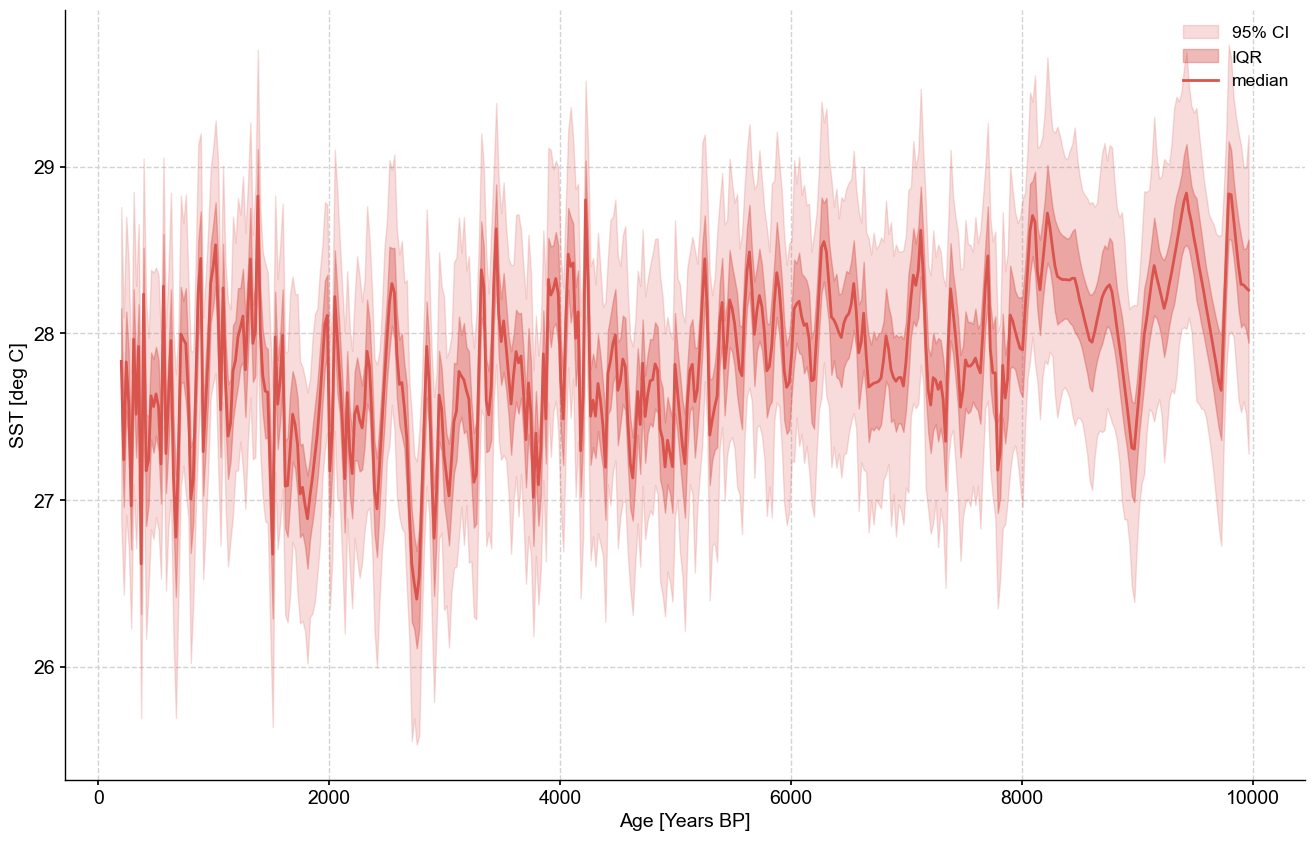

In [30]:
ensemble.common_time().plot_envelope(figsize=(16,10))